# Ordered phases in rydberg systems

In this example notebook, we will introduce the ordered phases in Rydberg systems, with focus on the 1D $Z_2$ phase and the 2D checkerboard phase.

## Adiabatic evolution

We begin by importing the necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from braket.ahs.atom_arrangement import AtomArrangement

from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation

from utils import show_register, show_global_drive, show_final_avg_density, get_drive

from braket.devices import LocalSimulator

## 1D $Z_2$ phase 

Here we consider a 1D chain of 9 atoms with neighboring atoms separated by $5.5\mu m$. The setup of the system can be generated as follows

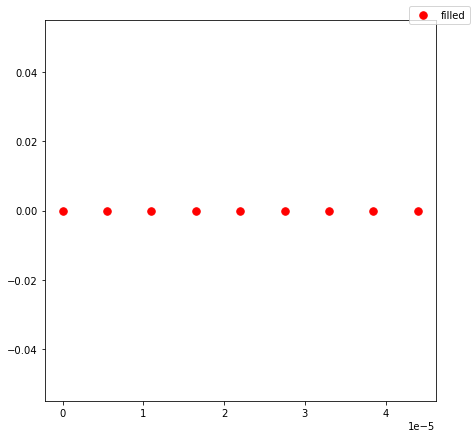

In [2]:
register = AtomArrangement()
separation = 5.5e-6  # in meters 
num_atoms = 9

for k in range(num_atoms):
    register.add((k*separation, 0))
    
show_register(register)

Let us plot the arrangment of the atoms and confirm that the setup is properly prepared. 

In order to prepare the $Z_2$ ordered state for the atomic chain, we shall design an analog Hamiltonian simulation  (AHS) program that drives the system adiabatically. The program consists three parts: the amplitude and phase of the Rabi frequency and the detuning. They can be specified as follows.

In [23]:
amplitude_min = 0       
amplitude_max = 8.3e6
detuning_min = -12e6
detuning_max = 30e6

time_max = 4e-6
time_ramp = 5e-7

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

We can plot the waveforms of these driving fields to make sure that they are correctly specified.

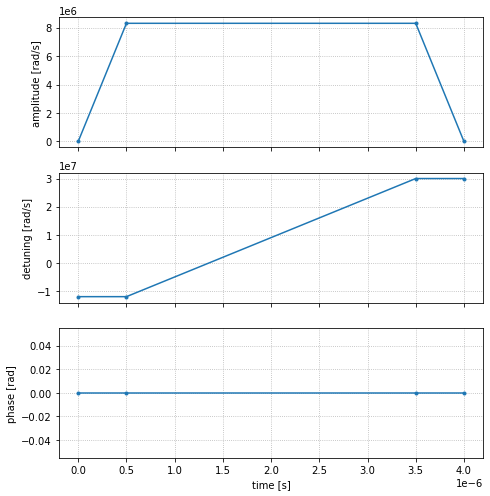

In [24]:
show_global_drive(drive)

Finally the AHS program of interest is the collection of the atomic registers, and the Hamiltonian defined above. 

In [25]:
ahs_program = AnalogHamiltonianSimulation(
    register=register, 
    hamiltonian=drive
)


Before runnig the program on Quera's device, we can first run it on the local simulator to make sure the outcome is the expected $Z_2$ state. 

Say sth about validation.

In [26]:
device = LocalSimulator("braket_ahs")

In [27]:
result = device.run(ahs_program, shots=100).result()

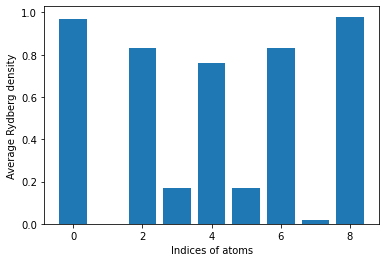

In [28]:
show_final_avg_density(result)

## 2D checkerboard phase 

In two dimension, Rydberg system can exhibit the checkerboard phase, which is analogues to the $Z_2$ phase in 1D. For simplicity, here we create a two dimensionl triangular atomic array. 

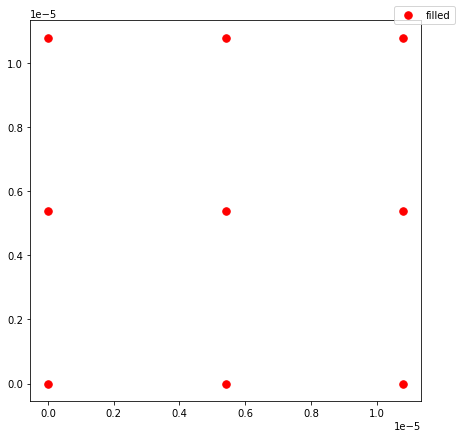

In [27]:
register_2D = AtomArrangement()
separation = 5.4e-6  # in meters 

for k in range(3):
    for l in range(3):
        register_2D.add((k * separation, l * separation))

show_register(register_2D)

Without loss of generality, we shall use the same Hamiltonian as the one used for realizing the $Z_2$ phase in the 1D atomic chain. 

In [28]:
amplitude_min = 0       
amplitude_max = 6.3e6 # good

detuning_min = -6e6
detuning_max = 20e6

time_max = 4e-6
time_ramp = 10e-7

time_points = [0, time_ramp, time_max - time_ramp, time_max]
amplitude_values = [amplitude_min, amplitude_max, amplitude_max, amplitude_min]
detuning_values = [detuning_min, detuning_min, detuning_max, detuning_max]
phase_values = [0, 0, 0, 0]


drive = get_drive(time_points, amplitude_values, detuning_values, phase_values)

ahs_program_2D = AnalogHamiltonianSimulation(
    register=register_2D, 
    hamiltonian=drive
)

device = LocalSimulator("braket_ahs")

result_2D = device.run(ahs_program_2D, shots=1000, steps=200).result()

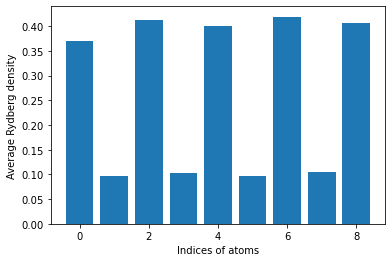

In [29]:
show_final_avg_density(result_2D)